In [562]:
import numpy as np
import scipy.stats as stats
from scipy.signal import peak_widths, find_peaks
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import itertools
from tqdm import tqdm
import pandas as pd
from matplotlib.collections import LineCollection

In [563]:
class DynaToy:
    def __init__(self, layer_sizes):
        self.layer_sizes = layer_sizes
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)
        self.W = np.zeros([len(self.r), len(self.r)])

        self.in_idx = np.arange(0, layer_sizes[0])
        self.out_idx = np.arange(len(self.r) - layer_sizes[-1], len(self.r))
        self.vth = np.zeros_like(self.r)

        self.W_ff_0 = 0.03
        self.W_ff_1 = 0.03
        self.W_fb_0 = 0.03
        self.W_fb_1 = 0.03

        self.W_r_0 = 0.03
        self.W_r_1 = 0.03

        self.dt = 1
        self.tau = 10   

    
    def init_weights(self, kappas = [], plot = False, return_matrices = False, recurrence = False, norm = False):
        W = np.zeros_like(self.W)
        W_L = []

        
        if not kappas:
            self.kappas = [1 for i in range(len(self.layer_sizes))]
        else:
            self.kappas = kappas

        # FF and FB connection weights
        for i in range(len(self.layer_sizes) - 1):
            rstart = int(np.sum(self.layer_sizes[:(i+1)]))
            rstop = rstart + self.layer_sizes[i+1]

            cstart = int(np.sum(self.layer_sizes[:i]))
            cstop = cstart + self.layer_sizes[i]

            shape = (self.layer_sizes[i+1], self.layer_sizes[i])

            W_l = np.zeros(shape)
            x = np.linspace(0, 2*np.pi, shape[1])

            for ii in range(shape[0]):
                loc = ((ii/shape[0]) * 2*np.pi)
                rf = stats.vonmises.pdf(x, self.kappas[i], loc)
                if norm: rf /= np.linalg.norm(rf)
                W_l[ii, :] = rf

            
            W_L.append(W_l)
            
            # FF Weights
            W[rstart:rstop, cstart:cstop] = W_l  * self.W_ff_0 + self.W_ff_1
            # FB weights
            W[cstart:cstop, rstart:rstop] = W_l.T  * self.W_fb_0 + self.W_fb_1

        if recurrence == 'vonmises':
            start = 0
            k1, k2, s1, s2 = 10, 1, 1, 1
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))
                
                shape = [self.layer_sizes[i], self.layer_sizes[i]]
                W_l = np.zeros(shape)
                x = np.linspace(0, 2*np.pi, shape[1])

                for ii in range(shape[0]):
                    loc = ((ii/shape[0]) * 2*np.pi)
                    rf = stats.vonmises.pdf(x, k1, loc, scale = s1) - stats.vonmises.pdf(x, k2, loc, scale = s2) 
                    rf /= np.linalg.norm(rf)
                    W_l[ii, :] = rf * 1

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))

        if recurrence == 'cosine':
            start = 0
            for i in range(len(self.layer_sizes)):
                stop = int(np.sum(self.layer_sizes[:(i+1)]))

                W_l = self.cos_weights(layer = i, W_0 = self.W_r_0, W_1 = self.W_r_1)

                W[start:stop, start:stop] = W_l
                W_L.append(W_l)

                start = int(np.sum(self.layer_sizes[:(i+1)]))


        if plot:
            plt.imshow(W, vmin = -np.max(np.abs(W)), vmax = np.max(np.abs(W)), cmap = 'bwr')
            plt.title("Model Weights")
            plt.colorbar()

        if return_matrices:
            return W, W_L


        W /= np.linalg.norm(W)
        return W
    

    def step(self, r):    
        self.r = self.W @ r
        self.r /= np.linalg.norm(self.r)
        # self.r /= self.r.max()
        
        return self.r
    

    def euler(self, h):
        r = np.zeros_like(h)
        y = self.W @ self.r + h - self.vth
        y[y < 0] = 0

        r[:] = (1 - (self.dt/self.tau)) * self.r + (self.dt/self.tau) * y
        
        return r
    

    def W_theta(self, theta, W_0, W_1):
        return W_1 + 2*W_0 * np.cos(theta)


    def cos_weights(self, layer, W_0 = 0.3, W_1 = 1.5):
        delta = 2*np.pi/self.layer_sizes[0]
        grid_positions = np.arange(0, self.layer_sizes[layer])

        theta = np.linspace(0, 2*np.pi, self.layer_sizes[layer])

        W = np.zeros([theta.size, theta.size])

        # Set weights
        for i, j, in itertools.product(grid_positions, grid_positions):
            W[i, j] = self.W_theta(theta[i] - theta[j],  W_0, W_1) * (delta / (2*np.pi))

        return W
    

    def reset(self):
        self.layers = [np.zeros([m, 1]) for m in self.layer_sizes]

        self.r = np.concatenate(self.layers)

    
    def compute_widths(self):
        start = 0
        widths = np.zeros(len(self.layer_sizes))

        for i, layer in enumerate(self.layer_sizes):
            stop = start + layer
            response = self.r[start:stop].squeeze()

            peak, _ = find_peaks(response)
            width, _, _, _ = peak_widths(response, peak)

            if len(width) != 1:
                width = 0
            widths[i] = (width/layer) * 360
            
            start += self.layer_sizes[i]

        return widths
    

    def compute_amplitudes(self):
        start = 0
        amps = np.zeros(len(self.layer_sizes))

        for i, layer in enumerate(self.layer_sizes):
            stop = start + layer
            response = self.r[start:stop].squeeze()
            
            amps[i] = response.max()

            start += self.layer_sizes[i]

        return amps


    def plot(self, timecourse, h, stim_on = 0):
        # Plotting
        fig, axs = plt.subplots(2, 2, figsize = [18, 12])

        # Timecourse
        ax = axs[0, 0]
        fig1 = ax.imshow(timecourse, aspect = 'auto', interpolation='none', cmap = 'RdBu_r')
        cbar = fig.colorbar(fig1)
        cbar.minorticks_on()
        ax.set_title("Response Timecourse")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Nodes")
        pos = 0
        for i, layer in enumerate(self.layer_sizes):
            ax.text(0, 1-(pos/self.r.shape[0]), "Layer %d" % i, horizontalalignment='left',
                        verticalalignment='top', transform=ax.transAxes, color = 'white')
            pos += layer
            if i != len(self.layer_sizes)-1:
                ax.axhline(pos, color = 'black')
            
            
        # Amplitude
        ax = axs[0, 1]
        start = 0
        for i in range(len(self.layer_sizes)):
            if i+1:
                midpoint = int(start + self.layer_sizes[i]/2)
                timeseries = timecourse[midpoint, :]
                ax.plot(timeseries, label = 'Layer %d' % i)
            start += self.layer_sizes[i]

        ax.hlines(h.max(), xmin = 0, xmax = timecourse.shape[1], color = 'gray', linestyle = "--", label = 'Input Amplitude')
        if stim_on:
            ax.axvline(self, ymin = 0, ymax = 1, color = 'red', label = 'Stim Offset', alpha = 0.5)
        ax.legend()
        ax.set_title("Response Amplitude")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Amplitude at Center (Arbitrary Units)")

        # Compute widths in each layer, plot over time
        ax = axs[1, 0]

        start = 0
        Widths = np.zeros([len(self.layer_sizes), timecourse.shape[1]])

        for i, layer in enumerate(self.layer_sizes):
            stop = start + layer
            layer_timecourse = timecourse[start:stop, :]

            for t, response in enumerate(layer_timecourse.T):
                
                peak, _ = find_peaks(response)
                width, _, _, _ = peak_widths(response, peak)
                if len(width) != 1:
                    width = 0
                Widths[i, t] = (width/layer) * 360
            start += self.layer_sizes[i]
            ax.plot(Widths[i, :], label = 'Layer %d' % i)

        h_peak, _ = find_peaks(h.squeeze())
        h_width, _, _, _ = peak_widths(h.squeeze(), h_peak)
        h_width = h_width/h.shape[0] * 360

        ax.hlines(h_width, xmin = 0, xmax = timecourse.shape[1], color = 'gray', linestyle = "--", label = 'Input Width')
        if stim_on:
            ax.axvline(stim_on, ymin = 0, ymax = 1, color = 'red', alpha = 0.5, label = 'Stim Offset')
        ax.legend()
        ax.set_title("FWHM")
        ax.set_xlabel("Timestep")
        ax.set_ylabel("Width (in deg)")

        ax = axs[1, 1]
        eigvals = np.linalg.eigvals(self.W)
        # extract real part 
        x = [ele.real for ele in eigvals] 
        # extract imaginary part 
        y = [ele.imag for ele in eigvals]
        ax.scatter(x, y)
        circ = plt.Circle((0, 0), radius=1, edgecolor='b', facecolor='None')
        circ2 = plt.Circle((0, 0), radius=0.5, edgecolor='b', facecolor='None')
        circ3 = plt.Circle((0, 0), radius=1.5, edgecolor='b', facecolor='None')
        ax.add_patch(circ)
        ax.add_patch(circ2)
        ax.add_patch(circ3)
        ax.set_title("Eigenvalues")
        ax.set_xlabel("Real")
        ax.set_ylabel("Imag")

        plt.show()
            
        

def simulate(model, n_timesteps, stim_on, layer_sizes, k_input):
    # Each Layer's Center locations for computing peak tuning widths
    peaks = []
    pos = 0
    for i in range(len(model.layer_sizes)):
        peak  = pos + int(model.layer_sizes[i]/2) 
        peaks.append(peak)
        pos += model.layer_sizes[i]

    # Feedforward
    x_pos = 180
    theta = np.linspace(0, 2*np.pi, layer_sizes[0])
    h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
    # h/= h.max()
    h = np.expand_dims(h, 1)

    timecourse_ff = np.zeros([model.r.shape[0], n_timesteps])
    H_ff = np.zeros_like(timecourse_ff)
    Widths_ff = np.zeros([len(model.layer_sizes), n_timesteps])
    Amps_ff = np.zeros([len(model.layer_sizes), n_timesteps])

    for t in range(n_timesteps):
        x_in = np.zeros_like(model.r)
        if t < stim_on:
            x_in[model.in_idx] = h
            model.r = model.euler(h = x_in)
        else:
            model.r = model.euler(h = x_in)

        timecourse_ff[:, t] = model.r.squeeze()
        H_ff[:, t] = x_in.squeeze()
        Widths_ff[:, t] = model.compute_widths()
        Amps_ff[:, t] = model.compute_amplitudes()

    # Feedback
    h = model.r[model.out_idx]
    # plt.plot(h)
    model.reset()

    theta = np.linspace(0, 2*np.pi, layer_sizes[-1])
    # h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
    # h = np.expand_dims(h, 1)

    timecourse_fb = np.zeros([model.r.shape[0], n_timesteps])
    H_fb = np.zeros_like(timecourse_fb)
    Widths_fb = np.zeros([len(model.layer_sizes), n_timesteps])
    Amps_fb = np.zeros([len(model.layer_sizes), n_timesteps])

    for t in range(n_timesteps):
        x_in = np.zeros_like(model.r)
        if t < stim_on:
            x_in[model.out_idx] = h
            model.r = model.euler(h = x_in)
        else:
            model.r = model.euler(h = x_in)

        timecourse_fb[:, t] = model.r.squeeze()
        H_fb[:, t] = x_in.squeeze()
        Amps_fb[:, t] = model.compute_amplitudes()
        Widths_fb[:, t] = model.compute_widths()

    FF= {
        'timecourse': timecourse_ff,
        'input': H_ff,
        'amp': Amps_ff,
        'widths': Widths_ff
    }
    FB= {
        'timecourse': timecourse_fb,
        'input': H_fb,
        'amp': Amps_fb,
        'widths': Widths_fb
    }

    return FF, FB



# Main Model Parameters
- layer sizes: # of nodes in each 'layer'
- kappas: kappa parameters for the Von Mises functions that map connections from one layer's nodes to the next
- W_ff_0: Scalar that scales the FF weights 
- W_ff_1: Constant that shifts the FF weights. 
- W_fb_0: Scalar that scales the FB weights 
- W_fb_1: Constant that shifts the FB weights 

Recurrence and lateral connections are optional. 
- recurrence: String that declares what type of recurrence to use. Default is '' (none). Cosine works. Von Mises Explodes. 
- W_r_0: Scalar that scales the Recurrence weights
- W_r_1: Constant that shifts the Recurrence weights


# Simulation Parameters
- n_timesteps: # of timepoints
- x_pos: center of VonMises used to simulate the stimulus input signal
- stim_on: duration of stimulus input signal
- k_input: kappa parameter of the Von Mises used for the input signal


Could attention modulation work here by scaling the recurrent weights in each layer?

Or, Recurrent weights are exist in a state, such that, when inhibited, they sharpen the representation in a layer

# Tuning Widths

/var/folders/86/mx5k0dps5gb_vlv7mwrrymd00000gn/T/ipykernel_70854/68719457.py:194: MatplotlibDeprecationWarning: Starting from Matplotlib 3.6, colorbar() will steal space from the mappable's axes, rather than from the current axes, to place the colorbar.  To silence this warning, explicitly pass the 'ax' argument to colorbar().
  cbar = fig.colorbar(fig1)


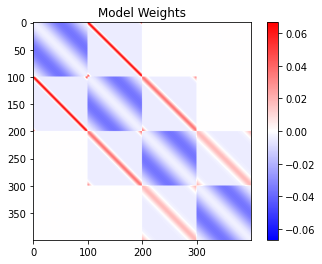

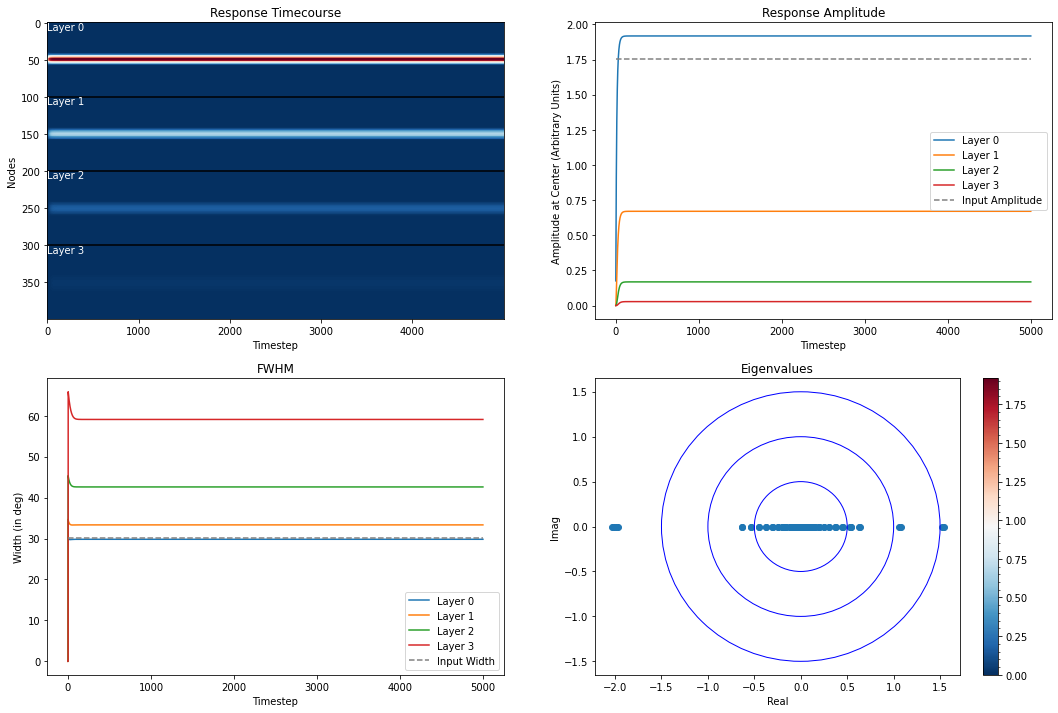

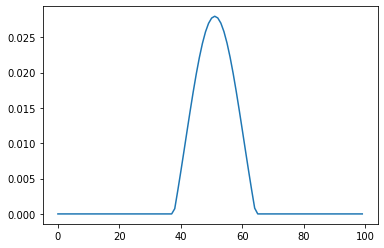

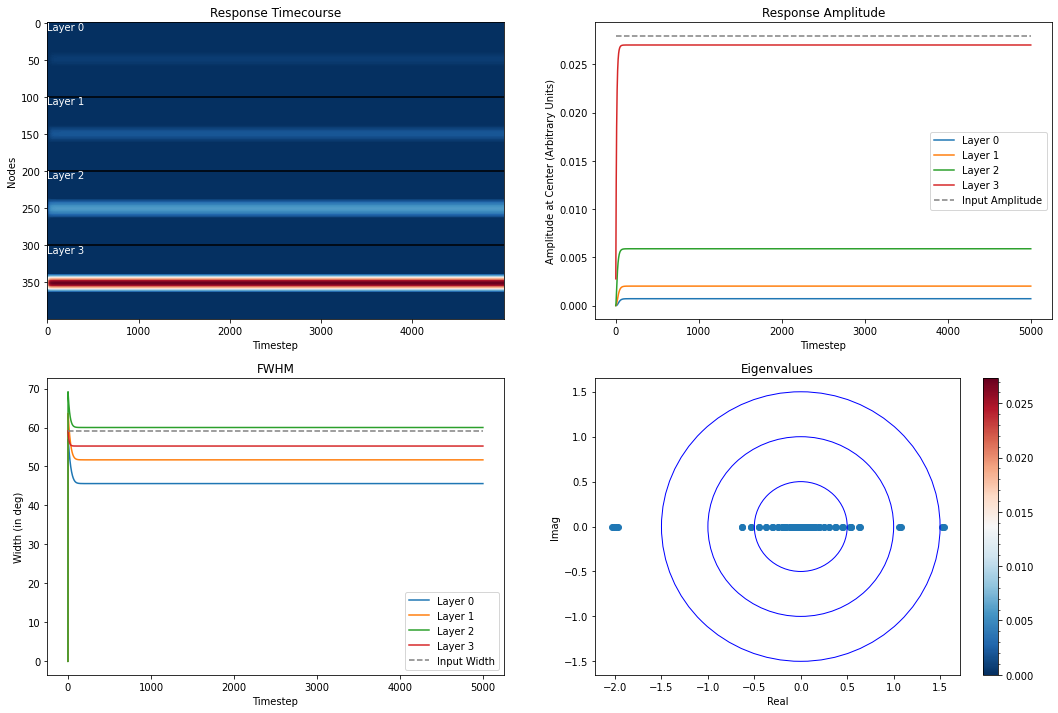

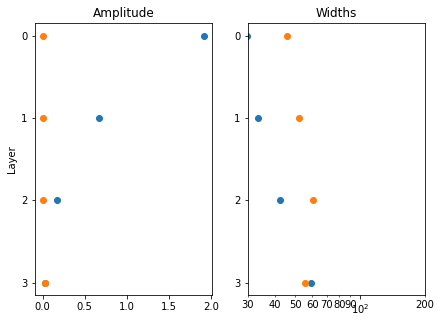

In [561]:
n_timesteps = 5000
stim_on = 5000

layer_sizes = [100, 100, 100, 100]
kappas = [36, 12, 4]            # 36, 12, 4, give similar tuning widths to perception condition
# kappas = [10, 10, 10]   # 
k_input = 20

model = DynaToy(layer_sizes)
model.W_ff_0 = .03     # Scales the FF weights - affects the next layer's amplitude
model.W_ff_1 = -.005      # Shifts the FF weights 
model.W_fb_0 = .03   # Scales the FB weights - affects the prev layer's amplitude
model.W_fb_1 = -.005        # Shifts the FB weights 


# Scale and Shift the Recurrence weights
model.W_r_0 = .8
model.W_r_1 = -2

recurrence = 'cosine'

model.W, W_L = model.init_weights(plot = True, kappas = kappas, return_matrices=True, recurrence = recurrence)

# Each Layer's Center locations for computing peak tuning widths
peaks = []
pos = 0
for i in range(len(model.layer_sizes)):
    peak  = pos + int(model.layer_sizes[i]/2) 
    peaks.append(peak)
    pos += model.layer_sizes[i]

# Feedforward
x_pos = 180
theta = np.linspace(0, 2*np.pi, layer_sizes[0])
h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
# h/= h.max()
h = np.expand_dims(h, 1)

timecourse_ff = np.zeros([model.r.shape[0], n_timesteps])
H = np.zeros_like(timecourse_ff)
Widths_ff = np.zeros([len(model.layer_sizes), n_timesteps])
Amps_ff = np.zeros([len(model.layer_sizes), n_timesteps])

for t in range(n_timesteps):
    x_in = np.zeros_like(model.r)
    if t < stim_on:
        x_in[model.in_idx] = h
        model.r = model.euler(h = x_in)
    else:
        model.r = model.euler(h = x_in)

    timecourse_ff[:, t] = model.r.squeeze()
    H[:, t] = x_in.squeeze()
    Widths_ff[:, t] = model.compute_widths()
    Amps_ff[:, t] = model.compute_amplitudes()
model.plot(timecourse_ff, h)

# Feedback
h = model.r[model.out_idx]
plt.plot(h)
model.reset()

theta = np.linspace(0, 2*np.pi, layer_sizes[-1])
# h = stats.vonmises.pdf(theta, k_input, np.radians(x_pos), 1)
# h = np.expand_dims(h, 1)

timecourse_fb = np.zeros([model.r.shape[0], n_timesteps])
H = np.zeros_like(timecourse_fb)
Widths_fb = np.zeros([len(model.layer_sizes), n_timesteps])
Amps_fb = np.zeros([len(model.layer_sizes), n_timesteps])

for t in range(n_timesteps):
    x_in = np.zeros_like(model.r)
    if t < stim_on:
        x_in[model.out_idx] = h
        model.r = model.euler(h = x_in)
    else:
        model.r = model.euler(h = x_in)

    timecourse_fb[:, t] = model.r.squeeze()
    H[:, t] = x_in.squeeze()
    Amps_fb[:, t] = model.compute_amplitudes()
    Widths_fb[:, t] = model.compute_widths()

model.plot(timecourse_fb, h)

fig, axs = plt.subplots(1, 2, figsize = [7, 5])

t = 250

# Amplitude
ax = axs[0]

ax.scatter(x = Amps_ff[:, t], y = [i for i in range(len(model.layer_sizes))])
ax.scatter(x = Amps_fb[:, t], y = [i for i in range(len(model.layer_sizes))])
ax.invert_yaxis()
ax.set_title("Amplitude")
ax.set_ylabel("Layer")
ax.set_yticks([i for i in range(len(model.layer_sizes))])

ax = axs[1]

ax.scatter(x = Widths_ff[:, t], y = [i for i in range(len(model.layer_sizes))])
ax.scatter(x = Widths_fb[:, t], y = [i for i in range(len(model.layer_sizes))])
ax.invert_yaxis()
ax.set_title("Widths")
ax.set_yticks([i for i in range(len(model.layer_sizes))])
ax.set_xlim([30, 200])
ax.set_xscale('log')
ax.xaxis.set_minor_formatter(mticker.ScalarFormatter())

## Iterate over parameter space

In [299]:
# Freeze strengths
FF_s = 0.05
FB_s = 0.05
# Freeze  recurrent scale
R_s = 0.5

# Recurrent Shift
R_0 = np.linspace(0, 1, 11)
R_1 = np.linspace(-2, 0, 11)


layer_sizes = [100, 100, 100, 100]
kappas = [36, 12, 4]            
#kappas = [10, 10, 10]    
k_input = 20
recurrence = 'cosine'

n_timesteps=5000
stim_on=5000

results = {}

# Simulate for each
model = DynaToy(layer_sizes)
model.W_ff_0 = 0.03
model.W_ff_1 = 0
model.W_fb_0 = 0.03
model.W_fb_1 = 0

S = np.zeros([R_0.shape[0], R_1.shape[0]])
S_n = np.zeros([R_0.shape[0], R_1.shape[0]])
rows = []
for i, params in tqdm(enumerate(itertools.product(R_0, R_1))):
    r_0, r_1 = params
    model.reset()

    # Scale and Shift the Recurrence weights
    model.W_r_0 = r_0
    model.W_r_1 = r_1

    model.W, W_L = model.init_weights(plot = False, kappas = kappas, return_matrices=True, recurrence = recurrence) 
    FF, FB = simulate(model, n_timesteps, stim_on, layer_sizes, k_input)

    key = "r0_" + str(r_0) + "_r1" + str(r_1)
    results["FF_" + key] = FF
    results["FB_" + key] = FB

    for i, layer in enumerate(layer_sizes):
        ff_row = [r_0, r_1, 'ff', i, layer, FF['amp'][i, stim_on-1], FF['widths'][i, stim_on-1], np.mean(FF['timecourse'][:, stim_on-1] - FF['timecourse'][:, int(stim_on/2)])]
        fb_row = [r_0, r_1, 'fb', i, layer, FB['amp'][i, stim_on-1], FB['widths'][i, stim_on-1], np.mean(FB['timecourse'][:, stim_on-1] - FB['timecourse'][:, int(stim_on/2)])]

        rows.append(ff_row)
        rows.append(fb_row)
    

121it [03:19,  1.65s/it]


In [300]:
df = pd.DataFrame(rows, columns = ['r_0', 'r_1', 'feed_direction', 'layer_num', 'layer_size', 'amp', 'width', 'mean_midend_diff'])
df

,r_0,r_1,feed_direction,layer_num,layer_size,amp,width,mean_midend_diff
0,0.0,-2.0,ff,0,100,1.712875e+00,27.963662,-3.469447e-20
1,0.0,-2.0,fb,0,100,6.123104e-04,51.364504,-1.050377e-118
2,0.0,-2.0,ff,1,100,5.842859e-01,31.870852,-3.469447e-20
3,0.0,-2.0,fb,1,100,1.748209e-03,58.140045,-1.050377e-118
4,0.0,-2.0,ff,2,100,1.447101e-01,43.057178,-3.469447e-20
...,...,...,...,...,...,...,...,...
963,1.0,0.0,fb,1,100,1.581345e+97,120.982176,4.049224e+96
964,1.0,0.0,ff,2,100,4.245272e+48,123.336228,1.163106e+48
965,1.0,0.0,fb,2,100,1.477944e+97,123.336238,4.049224e+96
966,1.0,0.0,ff,3,100,2.436180e+48,126.662928,1.163106e+48


In [373]:
stability_thresh = 1
R_ff_widths = np.zeros([len(R_0), len(R_1), len(layer_sizes)])
R_fb_widths = np.zeros([len(R_0), len(R_1), len(layer_sizes)])
R_ff_amps = np.zeros([len(R_0), len(R_1), len(layer_sizes)])
R_fb_amps = np.zeros([len(R_0), len(R_1), len(layer_sizes)])

R_ff_stability = np.zeros([len(R_0), len(R_1), len(layer_sizes)])
R_fb_stability = np.zeros([len(R_0), len(R_1), len(layer_sizes)])

for vals in itertools.product(R_0, R_1, df.layer_num.unique()):
    r0, r1, l = vals
    i = list(R_0).index(r0)
    j = list(R_1).index(r1)
    k = list(df.layer_num.unique()).index(l)

    R_ff_widths[i, j, k] = df.query('feed_direction == "ff" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').width
    R_fb_widths[i, j, k] = df.query('feed_direction == "fb" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').width
    R_ff_amps[i, j, k] = df.query('feed_direction == "ff" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').amp
    R_fb_amps[i, j, k] = df.query('feed_direction == "fb" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').amp

    R_ff_stability[i, j, k] = df.query('feed_direction == "ff" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').mean_midend_diff
    # R_ff_stability[R_ff_stability >= stability_thresh] = 0
    # R_ff_stability[R_ff_stability < stability_thresh] = 1
    
    ffs =  df.query('feed_direction == "ff" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').mean_midend_diff
    fbs =  df.query('feed_direction == "fb" & r_0 == @r0 & r_1 == @r1 & layer_num == @l').mean_midend_diff
    if ffs.values[0] > stability_thresh ** (k+1):
        R_ff_stability[i, j, k] = 0
    else:
        R_ff_stability[i, j, k] = 1

    if fbs.values[0] > stability_thresh ** (k+1):
        R_fb_stability[i, j, k] = 0
    else:
        R_fb_stability[i, j, k] = 1


    


/var/folders/86/mx5k0dps5gb_vlv7mwrrymd00000gn/T/ipykernel_70854/3576050010.py:8: RuntimeWarning: divide by zero encountered in log
  m1 = axs[0].imshow(np.log(R_ff_amps[:i, :j, k] * ff_stable_map), aspect = 'auto', interpolation = 'none', origin='lower')
/var/folders/86/mx5k0dps5gb_vlv7mwrrymd00000gn/T/ipykernel_70854/3576050010.py:10: RuntimeWarning: divide by zero encountered in log
  m3 = axs[2].imshow(np.log(R_fb_amps[:i, :j, k] * fb_stable_map), aspect = 'auto', interpolation = 'none', origin='lower')


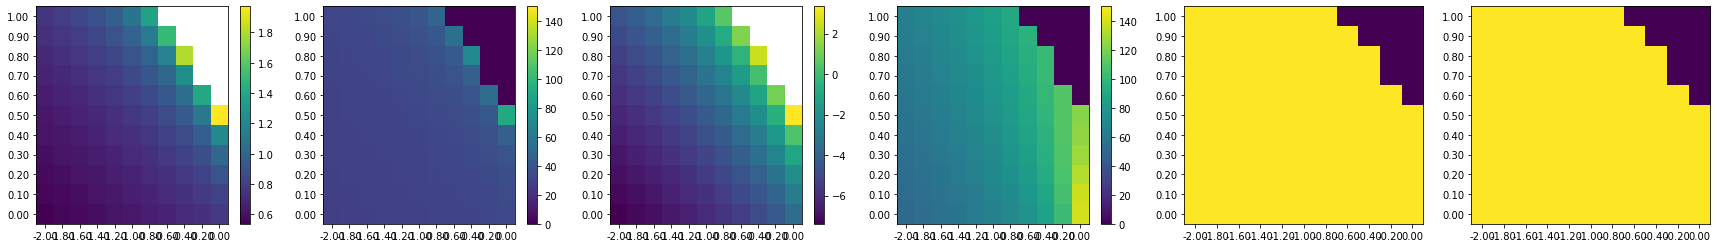

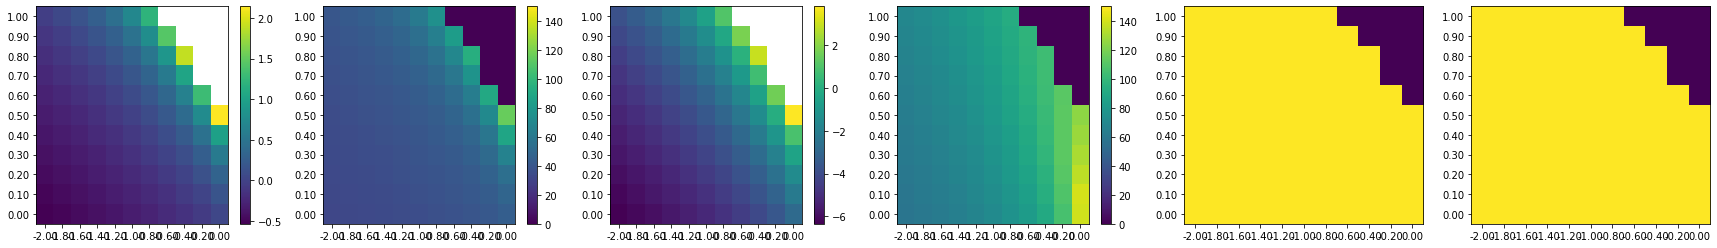

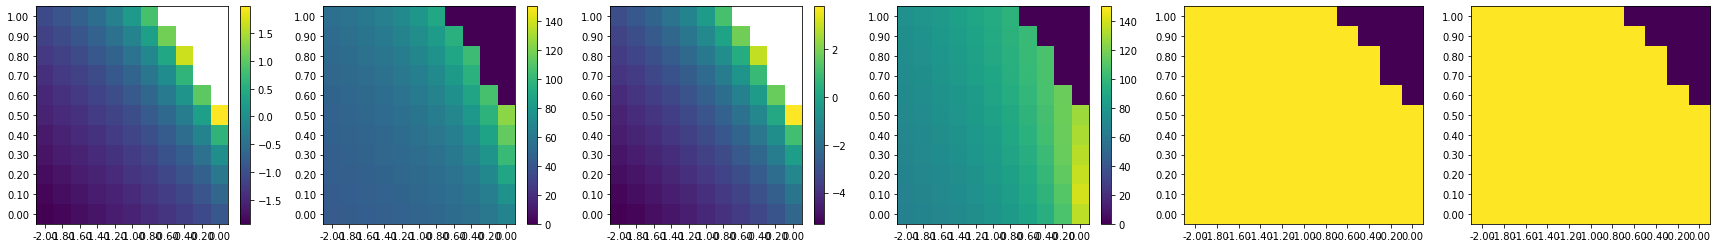

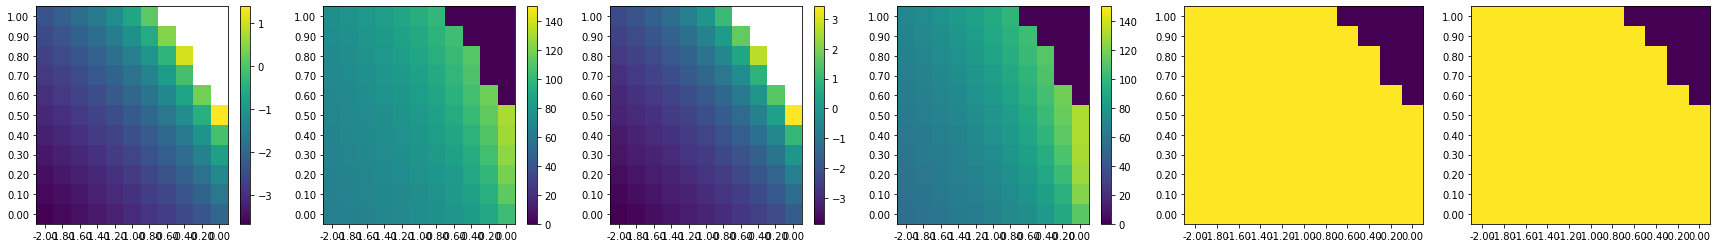

In [398]:
i, j = 11, 11
for k in df.layer_num.unique():
    fig, axs = plt.subplots(1, 6, figsize = [30, 4])

    ff_stable_map = R_ff_stability[:, :, k]
    fb_stable_map = R_fb_stability[:, :, k]

    m1 = axs[0].imshow(np.log(R_ff_amps[:i, :j, k] * ff_stable_map), aspect = 'auto', interpolation = 'none', origin='lower')
    m2 = axs[1].imshow(R_ff_widths[:, :, k] * ff_stable_map, aspect = 'auto', interpolation = 'none', origin='lower', vmin = 0, vmax = 150)
    m3 = axs[2].imshow(np.log(R_fb_amps[:i, :j, k] * fb_stable_map), aspect = 'auto', interpolation = 'none', origin='lower')
    m4 = axs[3].imshow(R_fb_widths[:, :, k] * fb_stable_map, aspect = 'auto', interpolation = 'none', origin='lower', vmin = 0, vmax = 150)

    axs[4].imshow(R_ff_stability[:, :, k], aspect = 'auto', interpolation = 'none', origin='lower')
    axs[5].imshow(R_fb_stability[:, :, k], aspect = 'auto', interpolation = 'none', origin='lower')

    axs[0].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[0].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])
    axs[1].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[1].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])
    axs[2].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[2].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])
    axs[3].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[3].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])
    axs[4].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[4].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])
    axs[5].set_yticks(range(len(R_0)), ['%0.02f'% r for r in R_0])
    axs[5].set_xticks(range(len(R_1)), ['%0.02f'% r for r in R_1])

    cbar1 = fig.colorbar(m1, ax = axs[0])
    cbar2 = fig.colorbar(m2, ax = axs[1])
    cbar3 = fig.colorbar(m3, ax = axs[2])
    cbar4 = fig.colorbar(m4, ax = axs[3])


    

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


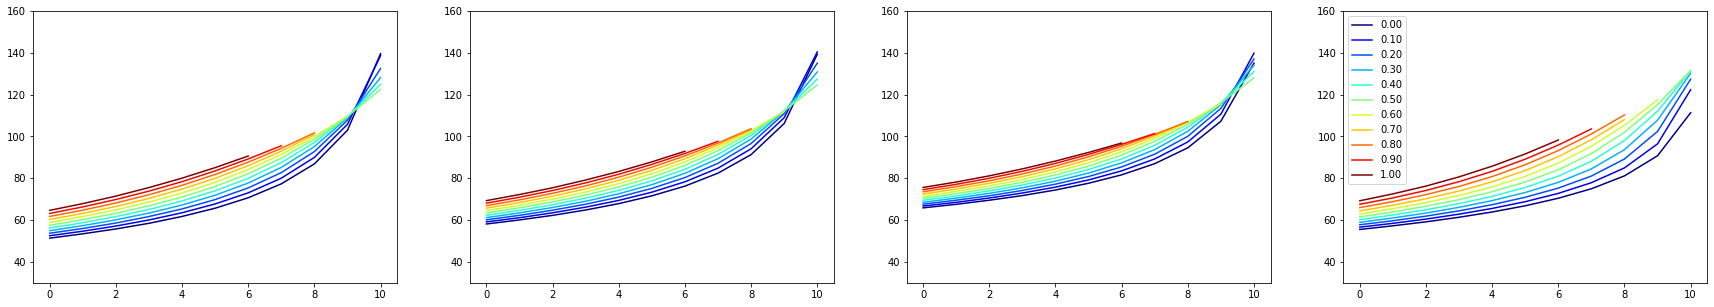

In [500]:
fig, axs = plt.subplots(1, 4, figsize = [30, 5])
colors = plt.cm.jet(np.linspace(0,1,len(R_0)))
for i in df.layer_num.unique():
    for j, row in enumerate(R_fb_widths[:, :, i]):

        row_stable = row * fb_stable_map[j]
        row_stable = [r for r in row_stable if r != 0]
        row_unstable = row


        # axs[i].plot(row_unstable, linestyle = ":")
        axs[i].plot(row_stable, label = '%0.02f' % R_0[j], color = colors[j])
        axs[i].set_ylim([30, 160])


    plt.legend()
    
    


In [522]:
rows = []
for i, g in df.groupby(['r_0', 'r_1', 'feed_direction'], as_index = False):
    y = g.width.values
    x = np.arange(4)

    y_centered, x_centered = y - y.mean(), x - x.mean()

    slope = y_centered.T@x_centered / (x_centered.T@x_centered)

    rows.append([i[0], i[1], i[2], slope])

df_slopes = pd.DataFrame(rows, columns = ['r_0', 'r_1', 'feed_direction', 'slope'])

In [523]:
df_slopes

,r_0,r_1,feed_direction,slope
0,0.0,-2.0,fb,2.015420
1,0.0,-2.0,ff,12.019976
2,0.0,-1.8,fb,1.899643
3,0.0,-1.8,ff,12.364409
4,0.0,-1.6,fb,1.743896
...,...,...,...,...
237,1.0,-0.4,ff,2.874878
238,1.0,-0.2,fb,2.577277
239,1.0,-0.2,ff,2.577249
240,1.0,0.0,fb,2.354199


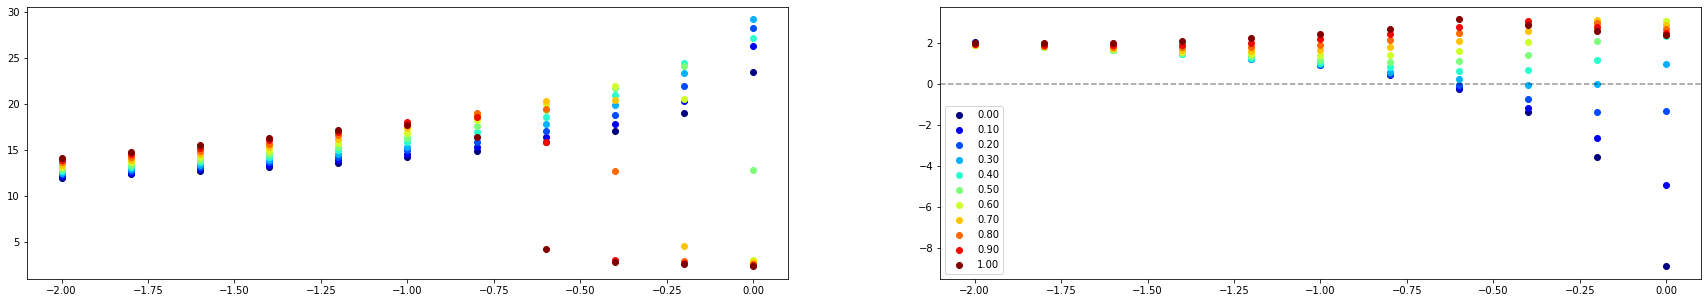

In [544]:
fig, axs = plt.subplots(1, 2, figsize = [30, 5])
colors = plt.cm.jet(np.linspace(0,1,len(R_0)))
for i, direct in enumerate(df.feed_direction.unique()):
    data  = df_slopes.query('feed_direction == @direct')
    for j, r in enumerate(R_0):
        d = data.query("r_0 == @r")

        # axs[i].plot(row_unstable, linestyle = ":")
        axs[i].scatter(x = d.r_1, y = d.slope, label = '%0.02f' % R_0[j], color = colors[j])

axs[1].axhline(y=0, linestyle = "--", alpha = 0.4, color = 'black')



plt.legend()

    
    


In [547]:
df_slopes.query('feed_direction == "fb" & r_1 == 0')

,r_0,r_1,feed_direction,slope
20,0.0,0.0,fb,-8.899379
42,0.1,0.0,fb,-4.950877
64,0.2,0.0,fb,-1.332229
86,0.3,0.0,fb,0.956651
108,0.4,0.0,fb,2.319754
130,0.5,0.0,fb,3.042285
152,0.6,0.0,fb,3.049111
174,0.7,0.0,fb,2.843001
196,0.8,0.0,fb,2.657047
218,0.9,0.0,fb,2.496243
